In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 30
CHANNELS = 3 # RGB channels

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE,IMAGE_SIZE)
)

Found 16011 files belonging to 10 classes.


In [4]:
len(dataset) # batches

501

In [5]:
501 * 32

16032

In [6]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

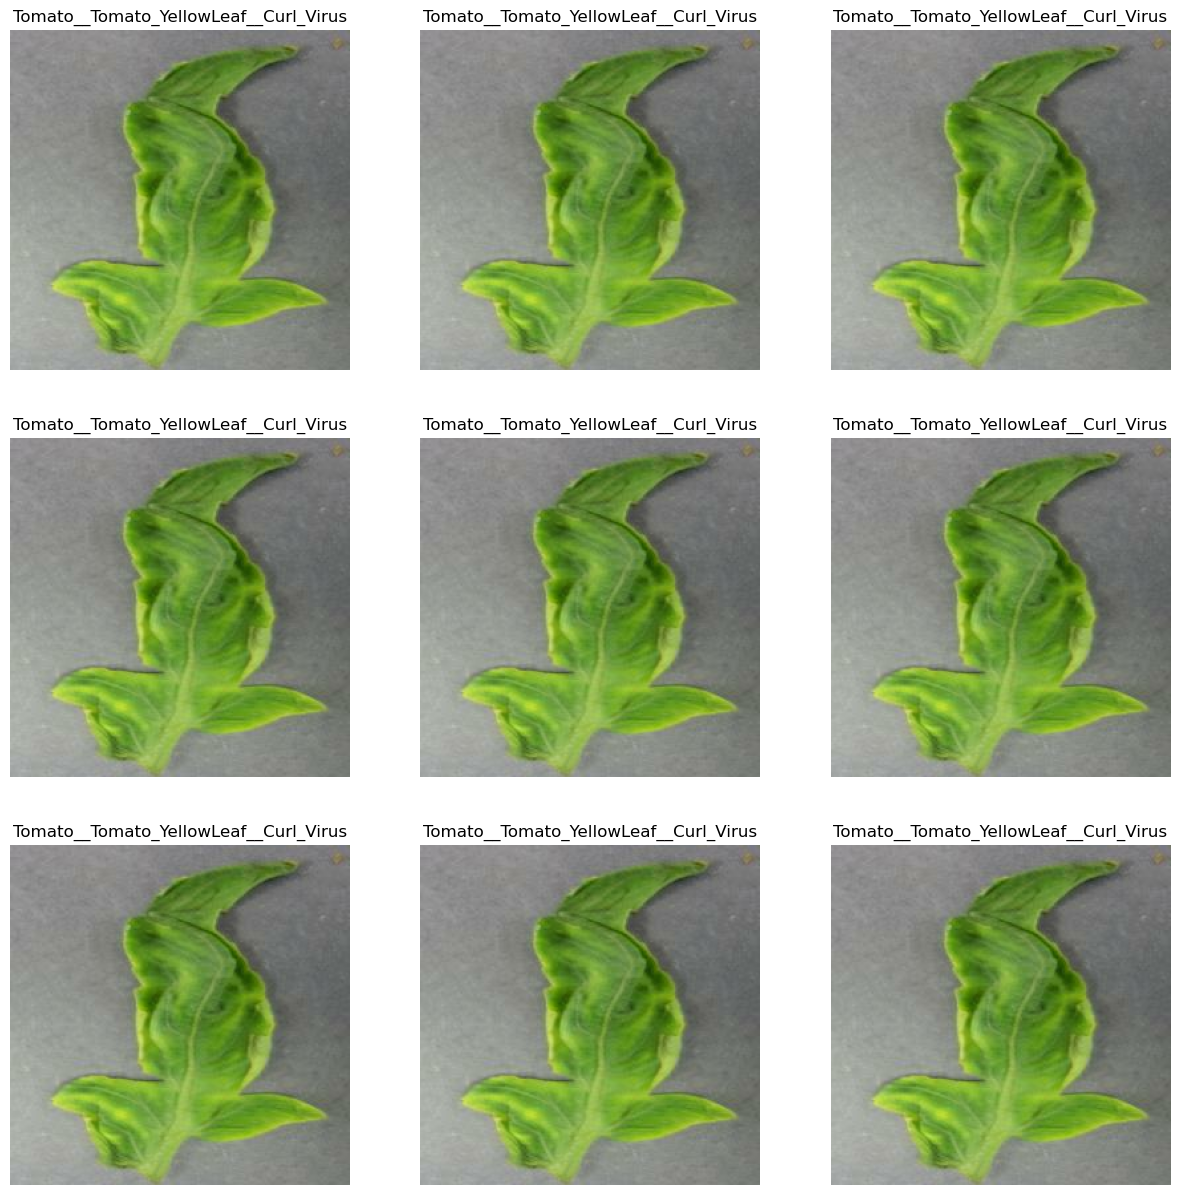

In [7]:
plt.figure(figsize=(15,15))
for images,labels in dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.title(class_names[labels[0]])
        plt.imshow(images[0].numpy().astype('uint8'))
        plt.axis('off')

**Train-Test-Split**

In [8]:
def train_test_split(df, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    df_size = len(df)
    train_size = int(train_split * df_size)
    val_size = int(val_split * df_size)

    train_df = df.take(train_size)
    val_df = df.skip(train_size).take(val_size)
    test_df = df.skip(train_size).skip(val_size)
    return train_df, val_df, test_df

In [9]:
train_df, val_df, test_df = train_test_split(dataset)

In [10]:
train_df

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [11]:
len(train_df)

400

In [12]:
len(val_df)

50

In [13]:
len(test_df)

51

In [14]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

**Data Augmentation**

In [15]:
import tensorflow as tf

# Check if TensorFlow can access the GPU
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")


GPU is not available


In [16]:
resize_rescale = models.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [17]:
data_aug = models.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

**Model Building and Training**

In [18]:
num_classes = len(class_names)
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS) # CHANNELS = RGB CHANNELS
model = models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(128, kernel_size=(3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Dense(num_classes,activation="softmax")
])

model.build(input_shape=input_shape)

In [19]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 1152)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 270,826 (1.03 MB)

 Trainable params: 270,826 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [21]:
history = model.fit(train_df, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=1,
                    validation_data=val_df)

Epoch 1/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 13684s 34s/step - accuracy: 0.3030 - loss: 1.9149 - val_accuracy: 0.5169 - val_loss: 1.3508
Epoch 2/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 482s 1s/step - accuracy: 0.5820 - loss: 1.1790 - val_accuracy: 0.7387 - val_loss: 0.7803
Epoch 3/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 930s 2s/step - accuracy: 0.7168 - loss: 0.7887 - val_accuracy: 0.7831 - val_loss: 0.6070
Epoch 4/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 1562s 4s/step - accuracy: 0.7993 - loss: 0.5751 - val_accuracy: 0.7675 - val_loss: 0.6728
Epoch 5/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 1529s 4s/step - accuracy: 0.8430 - loss: 0.4433 - val_accuracy: 0.7106 - val_loss: 0.9927
Epoch 6/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 1499s 4s/step - accuracy: 0.8611 - loss: 0.3932 - val_accuracy: 0.8863 - val_loss: 0.3457
Epoch 7/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 1385s 3s/step - accuracy: 0.8841 - loss: 0.3341 - val_accuracy: 0.7337 - val_loss: 1.0790
Epoch 8/30
400/400 ━━━━━━━━━━━━━━━━━━━━ 746s 2s/step - accuracy: 0.8926 - loss: 0.3204 - v

In [22]:
model.evaluate(test_df)

51/51 ━━━━━━━━━━━━━━━━━━━━ 15s 236ms/step - accuracy: 0.9729 - loss: 0.1084


[0.13556714355945587, 0.9621353149414062]

In [23]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 400}

In [24]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [25]:
accuracy = history.history['accuracy']
loss = history.history['loss']

val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

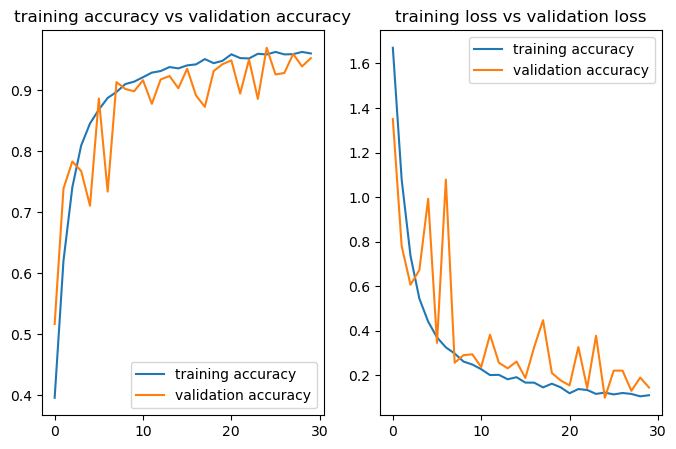

In [26]:
plt.figure(figsize=(8,5))
plt.subplot(1,2,1)
plt.plot(range(history.params['epochs']), accuracy, label="training accuracy")
plt.plot(range(history.params['epochs']), val_accuracy, label="validation accuracy")
plt.title("training accuracy vs validation accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(history.params['epochs']), loss, label="training accuracy")
plt.plot(range(history.params['epochs']), val_loss, label="validation accuracy")
plt.title("training loss vs validation loss")
plt.legend()

In [27]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.round(100 * max(predictions[0]), 2)

    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


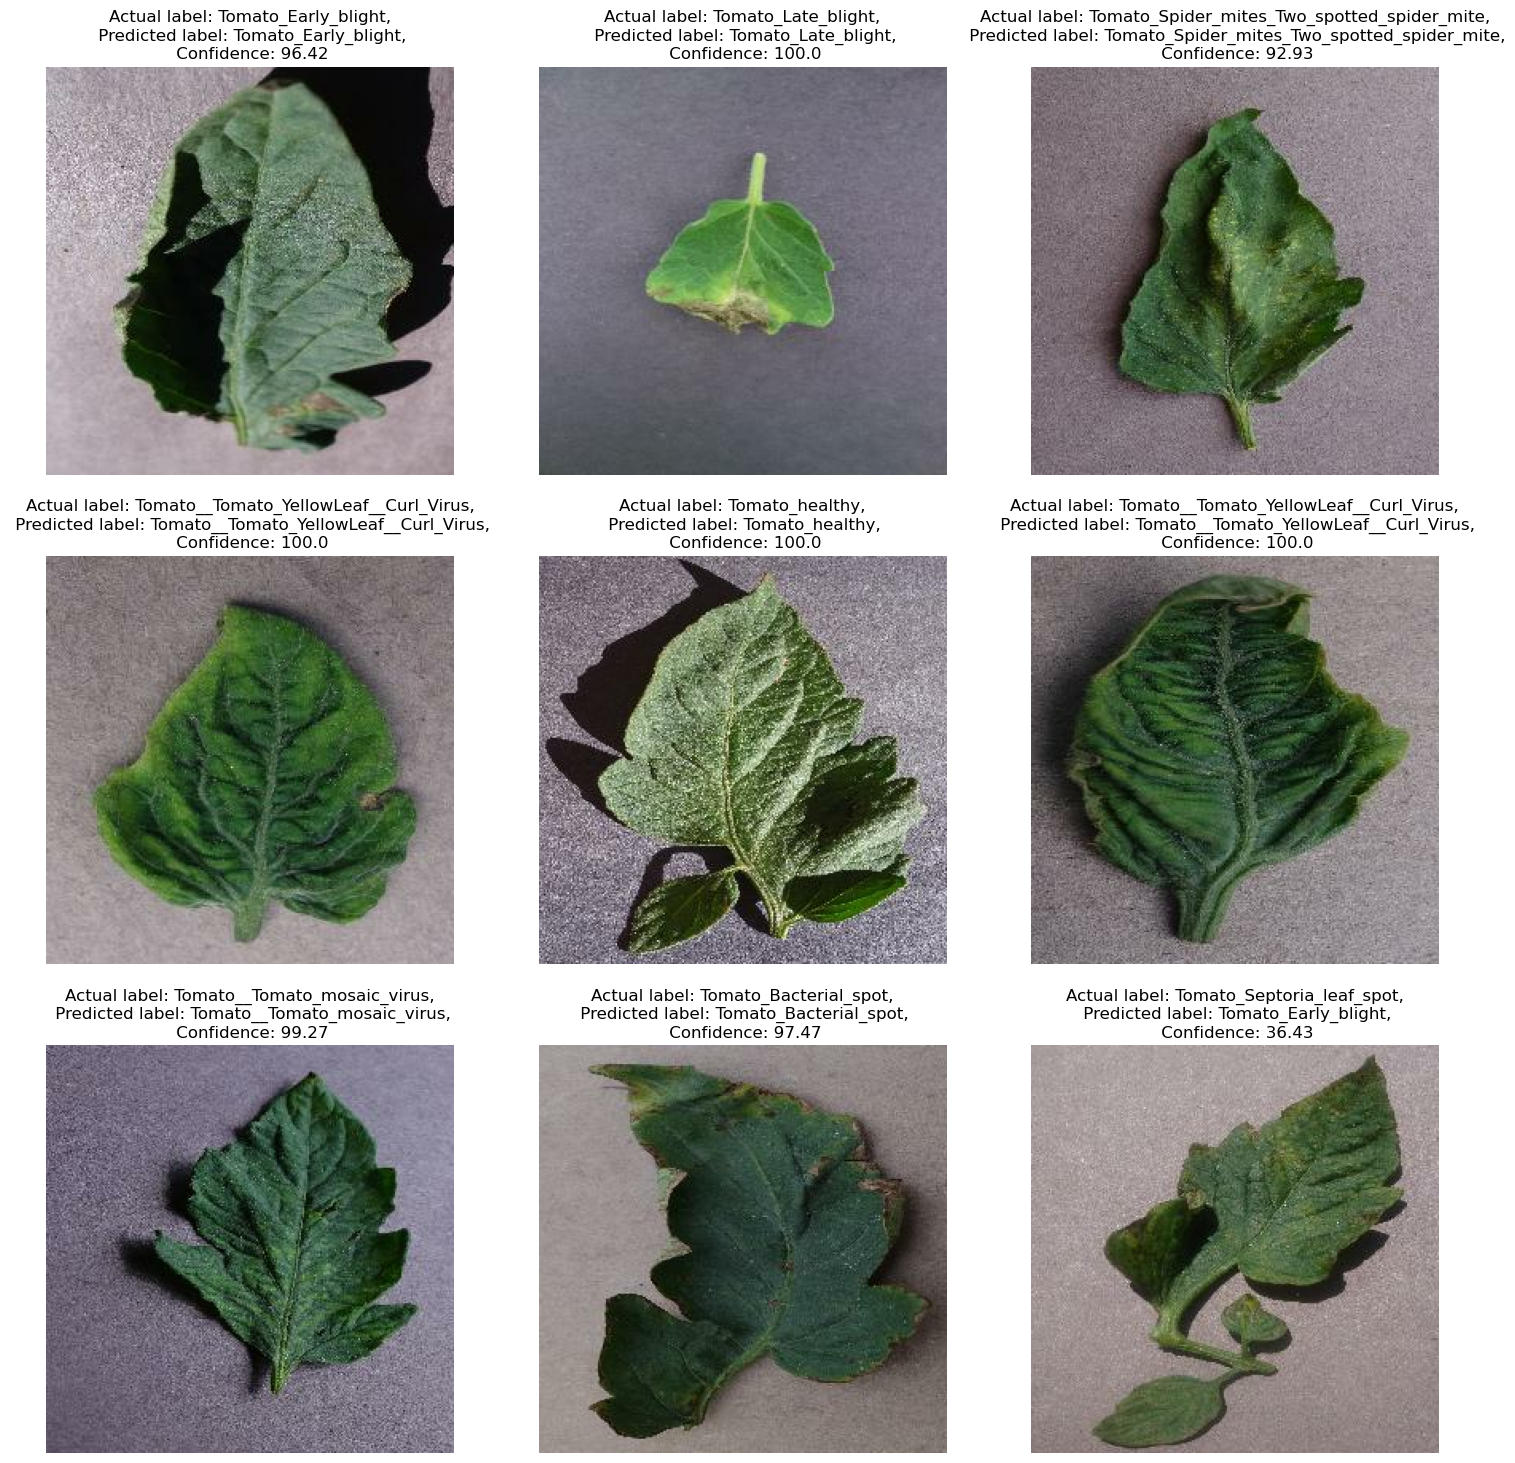

In [28]:
plt.figure(figsize=(18,18))
for images,labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual label: {actual_class},\n Predicted label: {predicted_class},\n Confidence: {confidence}")
        plt.axis('off')

In [1]:
# import os
# model_version = np.max([int(i) for i in os.listdir("../models")] + [0]) + 1
# model.save(f"../models/{model_version}")

In [30]:
import os
model_version = max([int(i) for i in os.listdir("../models")]) + 1
model.save(fr"C:\Users\tarus\deep_learning_codebasics\tomato_classification\models\{model_version}.h5")  # Using .h5 extension
model.save(fr"C:\Users\tarus\deep_learning_codebasics\tomato_classification\models\{model_version}.keras")  # Using .keras extension

In [3]:
from tensorflow import keras

# Load your Keras model
model = keras.models.load_model('C:/Users/tarus/deep_learning_codebasics/tomato_classification/models/3.h5')

# Export the model to the SavedModel format
model.export('C:/Users/tarus/deep_learning_codebasics/tomato_classification/models/1/')

INFO:tensorflow:Assets written to: C:/Users/tarus/deep_learning_codebasics/tomato_classification/models/1/assets


INFO:tensorflow:Assets written to: C:/Users/tarus/deep_learning_codebasics/tomato_classification/models/1/assets


Saved artifact at 'C:/Users/tarus/deep_learning_codebasics/tomato_classification/models/1/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1834315956048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834318496208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834318496592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834318497936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834318498128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834318498896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834318498512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834318499664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834318499856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1834318500624: TensorSpec(shape=(), dtype=tf.re